# Finetuning GPT2 To Generate Tweets in Specific User's Style

## Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import re
import transformers
import pathlib
import random
import os
import ipywidgets as widgets
from transformers import AutoTokenizer 
from transformers import AutoModelForCausalLM
from transformers import LineByLineTextDataset #TextDataset 
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer 
from transformers import TrainingArguments
from transformers import get_cosine_schedule_with_warmup
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Importing and Displaying Dataset

The dataset is downloaded from the http://vicinitas.io/ . Which could not further provide the free access to specific twitter user's tweets due to new Twitter API policies, but you can download tweets via API and preprocess them by just small tweaking of code.

In [24]:
data_path = "elonmusk_user_tweets.xlsx"

df = pd.read_excel(data_path)

df.head()

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1624920846166007808,🇺🇸🇺🇸🇺🇸 Go @Eagles!!! 🇺🇸🇺🇸🇺🇸,Elon Musk,elonmusk,2023-02-12T23:58:13.000Z,Sun Feb 12 23:58:13 +0000 2023,12362,1980,und,"<a href=""http://twitter.com/download/iphone"" r...",Tweet,NaN,0,1,NaN,NaN,NaN,NaN,NaN
1,1624903770529484801,@DrEliDavid 😂,Elon Musk,elonmusk,2023-02-12T22:50:22.000Z,Sun Feb 12 22:50:22 +0000 2023,2225,113,und,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,NaN,NaN,NaN,NaN
2,1624902165981712384,@teslaownersSV @RealDanODowd 🤣,Elon Musk,elonmusk,2023-02-12T22:44:00.000Z,Sun Feb 12 22:44:00 +0000 2023,1405,72,und,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,2,NaN,NaN,NaN,NaN,NaN
3,1624902091272749056,@Ali_TeslaMY @DavidSacks Actual reality of lob...,Elon Musk,elonmusk,2023-02-12T22:43:42.000Z,Sun Feb 12 22:43:42 +0000 2023,1576,86,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,2,NaN,NaN,NaN,NaN,NaN
4,1624901607480766466,@cb_doge Crazy that Starship is real!,Elon Musk,elonmusk,2023-02-12T22:41:47.000Z,Sun Feb 12 22:41:47 +0000 2023,2117,142,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,NaN,NaN,NaN,NaN


## Basic Exploratory Analysis

Exploratory Analysis:
Number of tweets: 3194
Languages present: en
### Name of Twitter User: Elon Musk
### Username of Twitter User: elonmusk


Dataset


# Basic Analysis
Bar Chart of the Number of Tweets by Tweet Type
Scatter Plot of Retweets vs Favorites
Retweets vs. Favorites

Tweets were posted from 2022-10-11 00:19:44+00:00 to 2023-02-12 23:58:13+00:00.
The duration of tweets since posted was 124 days 23:38:29.
Wordcloud For Tweets
There are 231739 words in the combination of all tweets.


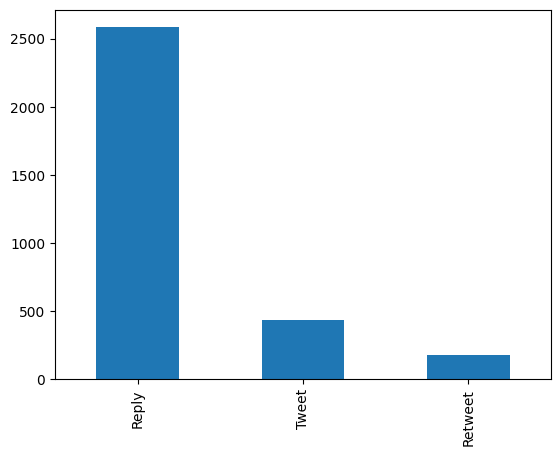

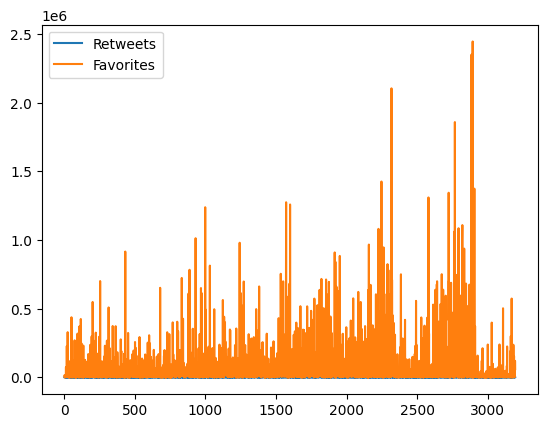

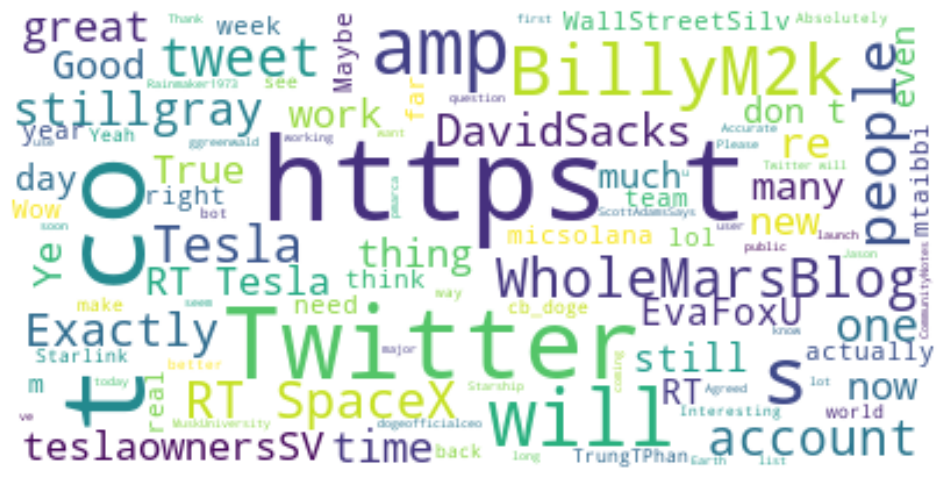

In [25]:
# Create a function to analyze the dataset
def analyze_data(df):
    print("Exploratory Analysis:")
    # Display some basic information about the data
    print(f"Number of tweets: {len(df)}")
    print(f"Languages present: {df['Language'].value_counts().idxmax()}")
    Name = df["Name"][0]
    Username = df["Screen Name"][0]
    print(f"""### Name of Twitter User: {Name}""")
    print(f"""### Username of Twitter User: {Username}""")
    # Display the data in a table
    print("\n\nDataset\n\n")
    df.head()
    
    # Convert created_at to datetime
    df["Created At"] = pd.to_datetime(df["Created At"], format='%a %b %d %H:%M:%S %z %Y')
    
    # Display 
    print("""# Basic Analysis""")
    print("Bar Chart of the Number of Tweets by Tweet Type")
    tweet_counts = df['Tweet Type'].value_counts().plot(kind="bar")
    

    # Display 
    print("Scatter Plot of Retweets vs Favorites")
    print("Retweets vs. Favorites")
    print("")

    scatter_data = df[['Retweets', 'Favorites']].plot()
    #df.plot(scatter_data)
    
    # Convert the 'Created At' column to a datetime format
    df['Created At'] = pd.to_datetime(df['Created At'], format='%a %b %d %H:%M:%S %z %Y')

    # Calculate the duration of tweets from when to when tweets were posted
    start_time = df['Created At'].min()
    end_time = df['Created At'].max()
    duration = end_time - start_time

    print(f"Tweets were posted from {start_time} to {end_time}.")
    print(f"The duration of tweets since posted was {duration}.")
    print("Wordcloud For Tweets")
    text = " ".join(tweet for tweet in df.Text)
    print("There are {} words in the combination of all tweets.".format(len(text)))
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

analyze_data(df)

## Data Preparation For Finetuning

In [12]:
# Create functions to preprocess the dataset
ALLOW_NEW_LINES = False


def fix_text(text):
        text = text.replace('&amp;', '&')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        return text
    
def clean_tweet(tweet, allow_new_lines = ALLOW_NEW_LINES):
        bad_start = ['http:', 'https:']
        for w in bad_start:
            tweet = re.sub(f" {w}\\S+", "", tweet)      # removes white space before url
            tweet = re.sub(f"{w}\\S+ ", "", tweet)      # in case a tweet starts with a url
            tweet = re.sub(f"\n{w}\\S+ ", "", tweet)    # in case the url is on a new line
            tweet = re.sub(f"\n{w}\\S+", "", tweet)     # in case the url is alone on a new line
            tweet = re.sub(f"{w}\\S+", "", tweet)       # any other case?
        tweet = re.sub(' +', ' ', tweet)                # replace multiple spaces with one space
        if not allow_new_lines:                         # TODO: predictions seem better without new lines
            tweet = ' '.join(tweet.split())
        return tweet.strip()

def boring_tweet(tweet):
        "Check if this is a boring tweet"
        boring_stuff = ['http', '@', '#']
        not_boring_words = len([None for w in tweet.split() if all(bs not in w.lower() for bs in boring_stuff)])
        return not_boring_words < 3

def preprocess_data(df):
    print("Preprocessing Dataset:")
    # Do preprocessing here and display results
    res = {}
    res["tweets"] = df["Text"].tolist()
    res['n_tweets'] = len(res["tweets"])
    res['n_RT'] = df.Retweets.sum()
    all_tweets = res["tweets"]
    cool_tweets = []
#     handles_processed = []
    raw_tweets = []
    user_names = []
    n_tweets_dl = []
    n_retweets = []
    n_short_tweets = []
    n_tweets_kept = []
    i = 0
    raw_tweets.append(all_tweets)
    curated_tweets = [fix_text(tweet) for tweet in all_tweets]
    # create dataset
    clean_tweets = [clean_tweet(tweet) for tweet in curated_tweets]
    cool_tweets.append([tweet for tweet in clean_tweets if not boring_tweet(tweet)])
    # save count
    n_tweets_dl.append(str(res['n_tweets']))
    n_retweets.append(str(res['n_RT']))
    n_short_tweets.append(str(len(all_tweets) - len(cool_tweets[-1])))
    n_tweets_kept.append(str(len(cool_tweets[-1])))
    
    if len('<|endoftext|>'.join(cool_tweets[-1])) < 6000:
        # need about 4000 chars for one data sample (but depends on spaces, etc)
        raise ValueError(f"Error: this user does not have enough tweets to train a Neural Network\n{res['n_tweets']} tweets downloaded, including {res['n_RT']} RT's and {len(all_tweets) - len(cool_tweets)} boring tweets... only {len(cool_tweets)} tweets kept!")
    if len('<|endoftext|>'.join(cool_tweets[-1])) < 40000:
        print('\n<b>Warning: this user does not have many tweets which may impact the results of the Neural Network</b>\n')
    print(f"\n{n_tweets_dl[-1]} tweets detected, including {n_retweets[-1]} RT's and {n_short_tweets[-1]} short tweets... keeping {n_tweets_kept[-1]} tweets\n\n\n")
    # create a file based on multiple epochs with tweets mixed up
    seed_data = random.randint(0,2**32-1)
    dataRandom = random.Random(seed_data)
    total_text = '<|endoftext|>'
    all_handle_tweets = []
    epoch_len = max(len(''.join(cool_tweet)) for cool_tweet in cool_tweets)
    for _ in range(4):
        for cool_tweet in cool_tweets:
            dataRandom.shuffle(cool_tweet)
            current_tweet = cool_tweet
            current_len = len(''.join(current_tweet))
            while current_len < epoch_len:
                for t in cool_tweet:
                    current_tweet.append(t)
                    current_len += len(t)
                    if current_len >= epoch_len: break
            dataRandom.shuffle(current_tweet)
            all_handle_tweets.extend(current_tweet)
            total_text += '<|endoftext|>'.join(all_handle_tweets) + '<|endoftext|>'

    print('\nCreating dataset...')
    with open(f"data_{df['Screen Name'][0]}_train.txt", 'w', encoding='utf-8') as f:
        f.write(total_text)
    print('\n🎉 Dataset created successfully!')
    print('\n🎉 Dataset saved successfully!')
    

preprocess_data(df)

Preprocessing Dataset:

3194 tweets detected, including 21044492 RT's and 1035 short tweets... keeping 2159 tweets




Creating dataset...

🎉 Dataset created successfully!

🎉 Dataset saved successfully!


## Finetuning GPT2

In [21]:
processed_dataset_path = "data_elonmusk_train.txt"

def finetune():
    print("Finetuning started...")
    os.environ["WANDB_DISABLED"] = "true"
    progress = widgets.FloatProgress(value=0.1, min=0.0, max=1.0, bar_style = 'info')

    # HYPER-PARAMETERS
    ALLOW_NEW_LINES = False     # seems to work better
    LEARNING_RATE = 1.372e-4
    EPOCHS = 2
    
    global trainer
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    model = AutoModelForCausalLM.from_pretrained('gpt2', cache_dir=pathlib.Path('cache').resolve())
    block_size = 100 #tokenizer.model_max_length
    print(block_size)
    tokenizer.pad_token = tokenizer.eos_token
    train_dataset = LineByLineTextDataset(tokenizer=tokenizer, file_path=processed_dataset_path, block_size=block_size)#, overwrite_cache=True)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    seed = random.randint(0,2**32-1)
    training_args = TrainingArguments(
                    output_dir=f"output0",
                    overwrite_output_dir=True,
                    do_train=True,
                    num_train_epochs=EPOCHS,
                    per_device_train_batch_size=1,
                    prediction_loss_only=True,
                    logging_steps=5,
                    save_steps=0,
                    seed=seed,
                    learning_rate = LEARNING_RATE,
                    report_to="none")
    trainer = Trainer(
                    model=model,
                    tokenizer=tokenizer,
                    args=training_args,
                    data_collator=data_collator,
                    train_dataset=train_dataset)
                
    # Update lr scheduler
    train_dataloader = trainer.get_train_dataloader()
    num_train_steps = len(train_dataloader)
    trainer.create_optimizer_and_scheduler(num_train_steps)
    trainer.lr_scheduler = get_cosine_schedule_with_warmup(
                    trainer.optimizer,
                    num_warmup_steps=0,
                    num_training_steps=num_train_steps)

    p_start, p_end = 0.4, 0.9
    def progressify(f):
        "Control progress bar when calling f"
        def inner(*args, **kwargs):
            if trainer.state.epoch is not None:
                # we only have one epoch, EPOCHS is built into dataset
                progress.value = p_start + trainer.state.epoch * (p_end - p_start)
            return f(*args, **kwargs)
        return inner
        
    trainer.training_step = progressify(trainer.training_step)
    trainer.train()

    # set model config parameters
    trainer.model.config.task_specific_params['text-generation'] = {
                    'do_sample': True,
                    'min_length': 10,
                    'max_length': 160,
                    'temperature': 1.,
                    'top_p': 0.95,
                    'prefix': '<|endoftext|>'}

    model_name = "elonmusk"
    # save new model files
    trainer.save_model(model_name)
    print("🎉 GPT2 finetuned successfully!")

finetune()

## Prediction over Finetuned GPT2

In [22]:
def prediction(start):
    predictions = []
    
    def shorten_text(text, max_char):
        while len(text) > max_char:
            text = ' '.join(text.split()[:-1]) + '…'
        return text
    #start = "My dream is"
    # prepare input
    start_with_bos = '<|endoftext|>' + start
    encoded_prompt = trainer.tokenizer(start_with_bos, add_special_tokens=False, return_tensors="pt").input_ids
    encoded_prompt = encoded_prompt.to(trainer.model.device)

    # prediction
    output_sequences = trainer.model.generate(
                    input_ids=encoded_prompt,
                    max_length=160,
                    min_length=10,
                    temperature=1.,
                    top_p=0.95,
                    do_sample=True,
                    num_return_sequences=10
                    )
    generated_sequences = []

    # decode prediction
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = trainer.tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        if not ALLOW_NEW_LINES:
            limit = text.find('\n')
            text = text[: limit if limit != -1 else None]
        generated_sequences.append(text.strip())
                
    for i, g in enumerate(generated_sequences):
        predictions.append([start, g])
        
    for pair in predictions:
        input_text = pair[0]
        output_text = pair[1]
        arrow = ' -> '
        preprocessed_text = input_text + arrow + output_text[len(input_text):]
        print(preprocessed_text)

In [ ]:
start = input("Write initial words to generate tweets e.g. My dream is: ")
prediction(start)